In [ ]:
import pandas as pd
import sklearn
from tqdm import tqdm
import numpy as np
import nltk
from nltk.corpus import stopwords
from torch import nn
from torch.optim import Adam
import torch

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Dataset
# repository https://github.com/iresiragusa/NLP/tree/main
# https://www.kaggle.com/datasets/yufengdev/bbc-fulltext-and-category?select=bbc-text.csv
# scarichiamo il dataset e lo carichiamo su COLAB

root = "/content/gdrive/MyDrive/Colab Notebooks/torch/"
df = pd.read_csv(root+"data/BBC-text/bbc-text.csv")

In [ ]:
# il dataset è formato da 2225 sample contenenti aricoli della BBC
# suddivisi in 5 categorie in base al loro topic

print('n sample -> '+str(len(df)))
labels = set(df['category'])
print('categories -> '+str(labels)+'['+str(len(labels))+']')
print(df['category'].value_counts())

# associo ad ogni categoria un indice, così ho delle label numeriche
labels_dict = {
    'business': 0,
    'politics': 1,
    'tech': 2,
    'sport': 3,
    'entertainment': 4
}

df['labels'] = df.apply(lambda row: labels_dict[row.category], axis = 1)

n sample -> 2225
categories -> {'politics', 'entertainment', 'tech', 'sport', 'business'}[5]
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

(x_train, x_test, y_train, y_test) = train_test_split(df['text'], df['labels'], test_size=0.2, random_state=17)

(x_train, x_val, y_train, y_val) = train_test_split(x_train, y_train, test_size=0.1, random_state=17)

# sarebbe uno split 72, 8, 20 per avere lo stesso test dell'altra volta

In [ ]:
print(len(x_train))
print(len(x_val))
print(len(x_test))

1602
178
445


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, x, y, stopwords):

        # x e y sono series di pandas
        tokens_litt = [nltk.word_tokenize(text, language='english')
         for text in list(x)]
        text_clean = []

        if stopwords:
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w.lower() for w in sentence if
                    not w.lower() in nltk.corpus.stopwords.words("english")]))
        else:
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w.lower() for w in sentence]))
            # ogni token è separato dall'altro con uno spazio

        self.texts = text_clean
        self.labels = [torch.tensor(label) for label in y]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        batch_texts = self.texts[idx]
        batch_labels = np.array(self.labels[idx])

        return batch_texts, batch_labels

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
hyperparameters = {
    "epochs": 5,
    "learning_rate": 1e-3,
    "batch_size": 64,
    "dropout": 0.1,
    "stopwords": False,
    "layers": 1,
    "h_dim": 300,
    "bilstm": True,
    "patience": 5,
    "min_delta": 0.01
}

In [ ]:
#creo i dataset

train_dataset = Dataset(x_train, y_train, hyperparameters["stopwords"])
val_dataset = Dataset(x_val, y_val, hyperparameters["stopwords"])
test_dataset = Dataset(x_test, y_test, hyperparameters["stopwords"])

Tokenizing ... : 100%|██████████| 445/445 [00:00<00:00, 20878.62it/s]


In [ ]:
# classe della rete

class EmbsLSTMClassifierDeep(nn.Module):

    def __init__(self, labels=5, lstm_layers=1,
                 lstm_hdim=50, bilstm=True, dropout=0.1):
        super(EmbsLSTMClassifierDeep, self).__init__()
        self.lstm = nn.LSTM(lstm_hdim, lstm_hdim, lstm_layers,
            bidirectional=bilstm, batch_first=True)
        if bilstm:
            lstm_output = lstm_hdim*2
        else :
            lstm_output = lstm_hdim
        self.bilstm = bilstm
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output, lstm_output),
            nn.BatchNorm1d(lstm_output),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(lstm_output, labels),
            )
        # non ho funzione di attivazione, è embedded nella loss
        # se devo calcolare l'accuracy, devo applicare una softmax/logsoftmax manualmente

    # parametri e output della LSMT -> https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
    def forward(self, input_texts):
        _output, (hn, _cn) = self.lstm(input_texts)
        if not self.bilstm:
            lstm_output = hn[-1,:,:]
        else:
            lstm_output = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim=1)
        final = self.classifier(lstm_output)
        return final

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                                # per asserire che c'è un miglioramenti della loss
        self.counter = 0                        # contatore delle epoche di pazienza
        self.early_stop = False                 # flag di early stop
        self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione

    def __call__(self, validation_loss):
        # chiamata in forma funzionale dell'oggetto di classe EarlySopping

        if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
            self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stop!")
        else:                                               # c'è un miglioramento della loss:
            self.min_validation_loss = validation_loss      # consideriamo la loss corrente
                                                            # come nuova loss ottimale
            self.counter = 0                                # e azzeriamo il contatore di pazienza


In [ ]:
import csv

# loading glove embeddings
def load_glove():
    #glove_path = root+"wordvectors/glove.6B.300d.txt"
    glove_path = root+"wordvectors/glove.6B.50d.txt"
    print("Loading glove vectors ...")
    with open(glove_path, encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONE)
        model = {line[0]: np.array(list(map(float, line[1:])))
                for line in reader}
    print("Glove vectors loaded")
    return model

# apply embeddings calculation
def gen_embeddings_glove(tokens, glove_embeddings):
    embeddings = []
    for sentence in tokens:
        emb = []
        for word in sentence:
            if word in glove_embeddings:
                emb.append(torch.tensor(glove_embeddings.get(word)))
        embeddings.append(torch.stack(emb))
    return embeddings

In [ ]:
# serve per il padding
def get_max_len(embeddings):
    max_len = 0
    for e in embeddings:
        if e.shape[0] > max_len: max_len = e.shape[0]
    return max_len

In [ ]:
def train_loop(model, dataloader, glove, loss, optimizer, device):
    model.train()

    epoch_acc = 0
    epoch_loss = 0

    for batch_texts, batch_labels in tqdm(dataloader, desc='training set'):

        optimizer.zero_grad()

        # tokenizzazione
        tokens = [nltk.word_tokenize(text, language='english') for text in list(batch_texts)]
        # embeddings
        embeddings = gen_embeddings_glove(tokens, glove)
        max_len_batch = get_max_len(embeddings)
        # padding
        input_embeddings =  torch.stack([torch.nn.functional.pad(x,(0,0,0, max_len_batch-x.shape[0])) for x in embeddings]).float().to(device)
        batch_labels = batch_labels.to(device)

        output = model(input_embeddings)

        # la loss è una CrossEntropyLoss, al suo interno ha
        # la logsoftmax + negative log likelihood loss
        batch_loss = loss(output, batch_labels)
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()

        # per calcolare l'accuracy devo generare le predizioni
        # applicando manualmente la logsoftmax
        softmax = nn.LogSoftmax(dim=1)
        epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()

        batch_labels = batch_labels.detach().cpu()
        input_embeddings = input_embeddings.detach().cpu()
        output = output.detach().cpu()

    return epoch_loss/len(dataloader), epoch_acc

In [ ]:
def test_loop(model, dataloader, glove, loss, device):
    model.eval()

    epoch_acc = 0
    epoch_loss = 0

    with torch.no_grad():

        for batch_texts, batch_labels, in tqdm(dataloader, desc='dev set'):

            # tokenizzazione
            tokens = [nltk.word_tokenize(text, language='english') for text in list(batch_texts)]
            # embeddings
            embeddings = gen_embeddings_glove(tokens, glove)
            max_len_batch = get_max_len(embeddings)
            # padding
            input_embeddings =  torch.stack([torch.nn.functional.pad(x, (0,0,0, max_len_batch-x.shape[0])) for x in embeddings]).float().to(device)
            batch_labels = batch_labels.to(device)

            output = model(input_embeddings)

            # la loss è una CrossEntropyLoss, al suo interno ha
            # la logsoftmax + negative log likelihood loss
            batch_loss = loss(output, batch_labels)
            epoch_loss += batch_loss.item()

            # per calcolare l'accuracy devo generare le predizioni
            # applicando manualmente la logsoftmax
            softmax = nn.LogSoftmax(dim=1)
            epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()

            batch_labels = batch_labels.detach().cpu()
            input_embeddings = input_embeddings.detach().cpu()
            output = output.detach().cpu()

    return epoch_loss/len(dataloader), epoch_acc

In [ ]:
def train_test(model,
               epochs,
               optimizer,
               device,
               train_data,
               test_data,
               batch_size,
               train_loss_fn,
               test_loss_fn=None,         # non necessariamente train e test loss devono differire
               early_stopping=None,       # posso addstrare senza early stopping
               val_data=None,             # e in questo caso non c'è validation set
               scheduler=None):           # possibile scheduler per monitorare l'andamento di un iperparametro,
                                          # tipicamente il learning rate

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    # check sulle funzioni di loss
    if test_loss_fn == None:
        test_loss_fn = train_loss_fn

    # liste dei valori di loss e accuracy epoca per epoca per il plot
    train_loss = []
    validation_loss = []
    test_loss = []

    train_acc = []
    validation_acc = []
    test_acc = []

    glove = load_glove()

    # Ciclo di addestramento con early stopping
    for epoch in tqdm(range(1,epochs+1)):

        epoch_train_loss, epoch_train_acc = train_loop(model,
                     train_dataloader, glove, train_loss_fn, optimizer, device)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc/len(train_data))

        # validation se è presente la callback di early stopping
        if early_stopping != None:
                epoch_validate_loss, epoch_validate_acc = test_loop(model, val_dataloader, glove, test_loss_fn, device)
                validation_loss.append(epoch_validate_loss)
                validation_acc.append(epoch_validate_acc/len(val_data))

        # test
        epoch_test_loss, epoch_test_acc,= test_loop(model, test_dataloader, glove, test_loss_fn, device)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc/len(test_data))

        val_loss_str = f'Validation loss: {epoch_validate_loss:6.4f} 'if early_stopping != None else ' '
        val_acc_str = f'Validation accuracy: {(epoch_validate_acc/len(val_data)):6.4f} ' if early_stopping != None else ' '
        print(f"\nTrain loss: {epoch_train_loss:6.4f} {val_loss_str} Test loss: {epoch_test_loss:6.4f}")
        print(f"Train accuracy: {(epoch_train_acc/len(train_data)):6.4f} {val_acc_str}Test accuracy: {(epoch_test_acc/len(test_data)):6.4f}")

        # early stopping
        if early_stopping != None:
                early_stopping(epoch_validate_loss)
                if early_stopping.early_stop:
                    break

    return train_loss, validation_loss, test_loss,
              train_acc, validation_acc, test_acc

In [ ]:
# Acquisiamo il device su cui effettueremo il training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = EmbsLSTMClassifierDeep(len(labels_dict),
                               hyperparameters["layers"],
                               50,
                               #hyperparameters["h_dim"],
                               hyperparameters["bilstm"],
                               hyperparameters["dropout"]).to(device)
print(model)

# Calcoliamo il numero totale dei parametri del modello
total_params = sum(p.numel() for p in model.parameters())
print(f"Numbero totale dei parametri: {total_params}")

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])

# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
early_stopping = EarlyStopping(patience=hyperparameters['patience'],
                               min_delta=hyperparameters['min_delta'])


Using cuda device
EmbsLSTMClassifierDeep(
  (lstm): LSTM(50, 50, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=5, bias=True)
  )
)
Numbero totale dei parametri: 51605


In [ ]:
# Routine di addestramento
train_loss, validation_loss,test_loss, train_acc, validation_acc, test_acc = train_test(model, hyperparameters['epochs'],
                                                                                optimizer, device, train_dataset,
                                                                                test_dataset, hyperparameters['batch_size'],
                                                                                criterion, criterion, early_stopping, val_dataset)

Loading glove vectors ...
Glove vectors loaded


training set: 100%|██████████| 26/26 [00:11<00:00,  2.27it/s]

dev set: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

 20%|██        | 1/5 [00:15<01:01, 15.42s/it]


Train loss: 1.1455 Validation loss: 1.3219 Test loss: 1.3277
Train accuracy: 0.5961 Validation accuracy: 0.7472 Test accuracy: 0.7393



training set: 100%|██████████| 26/26 [00:12<00:00,  2.02it/s]

dev set: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

 40%|████      | 2/5 [00:35<00:54, 18.33s/it]


Train loss: 0.6246 Validation loss: 0.5700 Test loss: 0.5943
Train accuracy: 0.8127 Validation accuracy: 0.8708 Test accuracy: 0.8157



training set: 100%|██████████| 26/26 [00:11<00:00,  2.34it/s]

dev set: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]

 60%|██████    | 3/5 [00:51<00:34, 17.19s/it]


Train loss: 0.4290 Validation loss: 0.3525 Test loss: 0.3503
Train accuracy: 0.8926 Validation accuracy: 0.9157 Test accuracy: 0.8876



training set: 100%|██████████| 26/26 [00:11<00:00,  2.20it/s]

dev set: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

 80%|████████  | 4/5 [01:09<00:17, 17.38s/it]


Train loss: 0.3048 Validation loss: 0.4146 Test loss: 0.3526
Train accuracy: 0.9051 Validation accuracy: 0.8764 Test accuracy: 0.8966



training set: 100%|██████████| 26/26 [00:11<00:00,  2.17it/s]

dev set: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

100%|██████████| 5/5 [01:25<00:00, 17.07s/it]


Train loss: 0.2742 Validation loss: 0.2397 Test loss: 0.2526
Train accuracy: 0.9139 Validation accuracy: 0.9382 Test accuracy: 0.9258


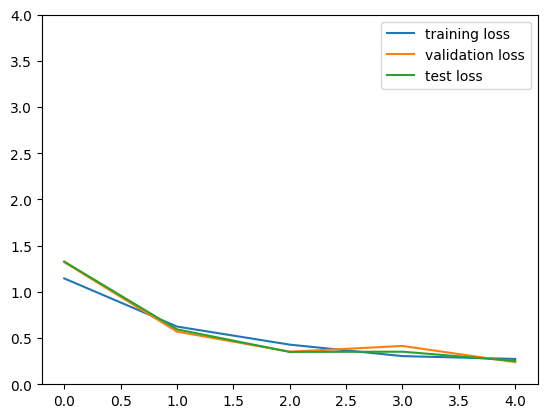

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.plot(test_loss, label='test loss')
plt.legend(loc='upper right')
plt.ylim(0,4)
plt.show()

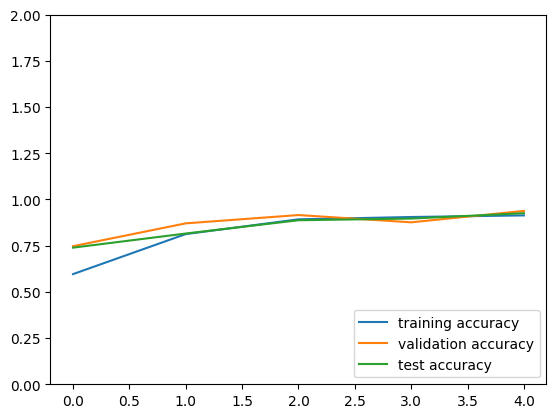

In [ ]:
plt.plot(train_acc, label='training accuracy')
plt.plot(validation_acc, label='validation accuracy')
plt.plot(test_acc, label='test accuracy')
plt.legend(loc='lower right')
plt.ylim(0,2)
plt.show()

In [ ]:
# save model

import os

model_path = root+'models/'

def save_model(net, optimizer, current_epoch, train_loss, val_loss, test_loss, path):

    # Abbiamo deciso per queste informazioni, ma possiamo caricare qualunque cosa
    torch.save({
            'epoch': current_epoch,
            'model_state_dict': net.state_dict(),
            # configurazione di tutti i layer *addestrabili* del modello
            'optimizer_state_dict': optimizer.state_dict(),
            # configurazione e iperparametri dell'ottimizzatore
            'training_loss': train_loss,
            'validation_loss': val_loss,
            'test_loss': test_loss,
            }, path)

In [ ]:
def load_model(path, hyperameters, labels_dict, ModelClass=nn.Module, OptimizerClass=torch.optim.Optimizer, device = None):

    # Ricarichiamo il dizionario e restituiamo la tupla delle informazioni
    # La rete e l'ottimizzatore devono essere inizializzate prima di caricare
    # lo stato salvato

    # Inizializziamo il modello con la classe di rete neurale richiesta
    model = ModelClass(len(labels_dict),
                        hyperparameters["layers"],
                        hyperparameters["h_dim"],
                        hyperparameters["bilstm"],
                        hyperparameters["dropout"])

    # Se il device è specificato e non è la CPU, allora muoviamo il modello sul device
    if device != None and device != 'cpu':
        model.to(device)

    # Analogo discorso per l'ottimizzatore
    optimizer = OptimizerClass(model.parameters(), lr=hyperparameters['learning_rate'])

    # carichiamo il model checkpoint
    checkpoint = torch.load(path)

    # inizializziamo lo stato del modello e dell'ottimizzatore
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # restituiamo tutte le informazioni in una tupla
    return (model, optimizer, checkpoint['epoch'], checkpoint['training_loss'],
            checkpoint['validation_loss'], checkpoint['test_loss'])

In [ ]:
save_model(model, optimizer, len(train_loss), train_loss, validation_loss, test_loss, os.path.join(model_path,'net1.pth'))

(mod, _opt, _ep, _tr_loss, _val_loss, _testloss) = load_model(os.path.join(model_path,'net1.pth'), EmbsLSTMClassifierDeep, torch.optim.Adam, device=device)

<ipython-input-34-05c099d05d20>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


In [ ]:
def evaluate(model, test_data, glove, device, pred_path):

    dataloader = torch.utils.data.DataLoader(test_data, batch_size=1)

    model.eval()

    acc = 0

    with torch.no_grad():

        for idx, (batch_texts, batch_labels) in enumerate(tqdm(dataloader, desc='evaluation')):

            # tokenizzazione
            tokens = [nltk.word_tokenize(text, language='english') for text in list(batch_texts)]
            # embeddings
            embeddings = gen_embeddings_glove(tokens, glove)
            max_len_batch = get_max_len(embeddings)
            # padding
            input_embeddings =  torch.stack([torch.nn.functional.pad(x,(0,0,0, max_len_batch-x.shape[0])) for x in embeddings]).float().to(device)
            batch_labels = batch_labels.to(device)

            output = model(input_embeddings)

            # per calcolare l'accuracy devo generare le predizioni
            # applicando manualmente la logsoftmax
            softmax = nn.LogSoftmax(dim=1)
            acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()

            batch_labels = batch_labels.detach().cpu()
            input_embeddings = input_embeddings.detach().cpu()
            output = output.detach().cpu()

            with open(pred_path, 'a') as f:
                f.write(f'{idx},{batch_labels},{softmax(output).argmax(dim=1)}\n')


    return acc

glove = load_glove()
predictions_path = os.path.join(root,'predictions/')
os.makedirs(predictions_path, exist_ok=True)
pred_path = predictions_path+'pred.csv'
with open(pred_path, 'w') as f:
    f.write('idx,label,pred\n')

acc = evaluate(model, test_dataset, glove, device, pred_path)

print(f'Accuracy {acc/len(test_dataset):.3}')

Loading glove vectors ...
Glove vectors loaded


evaluation: 100%|██████████| 445/445 [00:06<00:00, 63.66it/s]

Accuracy 0.915
